    problem                     search  expansions  tests  new nodes  \
0         1       breadth_first_search          43     56        180   
1         1  breadth_first_tree_search        1458   1459       5960   
2         1   depth_first_graph_search          12     13         48   
3         1       depth_limited_search         101    271        414   
4         1        uniform_cost_search          55     57        224   
5         2       breadth_first_search        3343   4609      30509   
6         2  breadth_first_tree_search           0      0          0   
7         2   depth_first_graph_search        1669   1670      14863   
8         2       depth_limited_search           0      0          0   
9         2        uniform_cost_search        4852   4854      44030   
10        3       breadth_first_search       14663  18098     129631   
11        3  breadth_first_tree_search           0      0          0   
12        3   depth_first_graph_search         592    593       

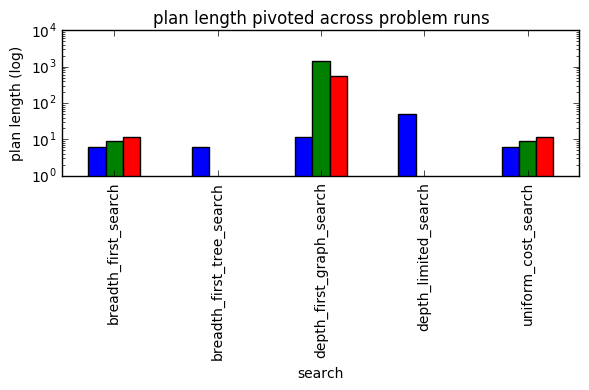

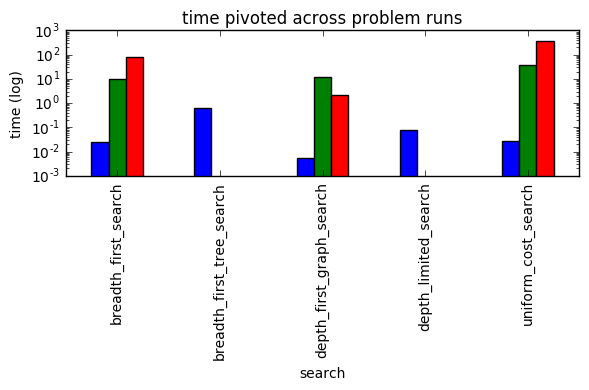

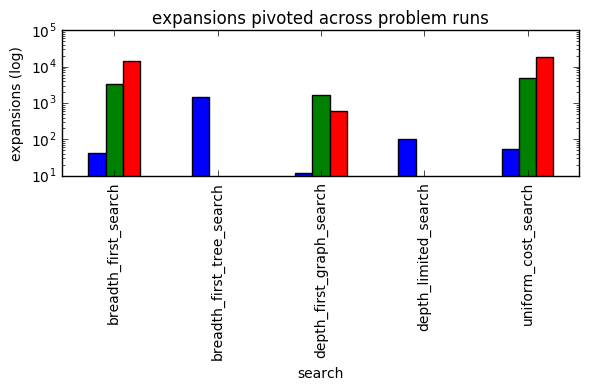

In [4]:
import matplotlib.pyplot as plt
import pandas as pd


search_map = {
    1: 'breadth_first_search',
    2: 'breadth_first_tree_search',
    3: 'depth_first_graph_search',
    4: 'depth_limited_search',
    5: 'uniform_cost_search'
}



df=pd.read_csv('uninformed.csv')
df['search'] = df['search'].map(search_map)
print(df)

labels = []
idx=1


for y in ['plan length', 'time', 'expansions']:
    a = df.pivot(index='search', columns='problem', values=y).plot(kind='bar', logy=True, legend=False)
    a.set_ylabel(y+" (log)")
    a.set_title(y+" pivoted across problem runs")
    fig = a.get_figure()
    plt.tight_layout()
    fig.savefig("img_{}.png".format(y.replace(' ','_')))
plt.show()